<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/TimeSeriesAnalysis_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Workflow
This colab uses the labeled CA data for Multivariate time series forecasting called Vector Autoregression
(VAR).



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture


import statsmodels.api as sm
from statsmodels.tsa.api import VAR

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [5]:
NY_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_labeledData_Sep26.csv',low_memory=False)
NY_labeled_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0,LessSpread,flat_growth,0.0,flat_growth,0.0
1,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,24913.0,LessSpread,flat_growth,0.0,flat_growth,0.0
2,2020-03-01,36021,Columbia County,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0,0.0,59461.0,LessSpread,flat_growth,0.0,flat_growth,0.0
3,2020-03-01,36095,Schoharie County,26.0,9.0,0.0,0.0,13.0,0.0,24.47,2.137,27,49.852047,0,0.0,0,0.0,30999.0,LessSpread,flat_growth,0.0,flat_growth,0.0
4,2020-03-01,36033,Franklin County,28.0,27.0,0.0,0.0,7.0,0.0,10.82,2.205,56,30.704920,0,0.0,0,0.0,50022.0,LessSpread,flat_growth,0.0,flat_growth,0.0


In [6]:
NY_labeled_data.columns

Index(['Date', 'fips_x', 'County Name', 'retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'rolling_avg_new_cases', 'population', 'label', 'growth_label',
       'New Cases/1k population', 'growth_label_1k', 'growth_1k_pop'],
      dtype='object')

In [7]:
columns = ['retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent','New Cases/1k population']

NY_labeled_data_filter = NY_labeled_data.filter(columns, axis=1)

In [7]:
NY_labeled_data_filter.head(3)

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New Cases/1k population
0,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0.0
1,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0.0
2,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0.0


# VAR- Implementation -Analytic Vidya + Old Code

In [80]:
NY_labeled_data['County Name'].unique

<bound method Series.unique of 0          Albany County
1           Yates County
2        Columbia County
3       Schoharie County
4        Franklin County
              ...       
9799       Seneca County
9800     Cortland County
9801      Steuben County
9802      Suffolk County
9803        Yates County
Name: County Name, Length: 9804, dtype: object>

In [81]:
NY_labeled_data[NY_labeled_data['County Name']=='New York County']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop
37,2020-03-01,36061,New York County,-3.0,2.0,-7.0,-3.0,1.0,0.0,-0.24,0.462,23,71340.604468,0,0.000,0,0.000000,1628706.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
60,2020-03-02,36061,New York County,3.0,6.0,17.0,-3.0,4.0,0.0,-3.70,1.896,96,71340.604468,0,0.000,1,0.000000,1628706.0,LessSpread,flat_growth,0.000614,mild_growth,0.000614
161,2020-03-03,36061,New York County,0.0,6.0,5.0,-1.0,3.0,0.0,-1.26,1.843,93,71340.604468,0,0.000,0,0.000000,1628706.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
184,2020-03-04,36061,New York County,3.0,9.0,13.0,-3.0,2.0,0.0,3.39,2.023,102,71340.604468,0,0.000,0,0.000000,1628706.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
242,2020-03-05,36061,New York County,2.0,10.0,14.0,-2.0,2.0,0.0,10.85,2.046,104,71340.604468,0,0.000,3,0.000000,1628706.0,LessSpread,flat_growth,0.001842,mild_growth,0.001842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,2020-08-17,36061,New York County,0.0,0.0,0.0,0.0,-64.0,18.0,-32.44,0.594,30,71340.604468,1,0.803,235,341.285714,1628706.0,LessSpread,mild_growth,0.144286,mild_growth,0.131408
9598,2020-08-18,36061,New York County,0.0,0.0,0.0,0.0,-63.0,18.0,-28.06,0.942,47,71340.604468,1,0.803,284,342.714286,1628706.0,LessSpread,mild_growth,0.174372,mild_growth,0.161279
9665,2020-08-19,36061,New York County,0.0,0.0,0.0,0.0,-64.0,19.0,-31.59,0.597,30,71340.604468,1,0.803,273,326.571429,1628706.0,LessSpread,mild_growth,0.167618,mild_growth,0.121926
9690,2020-08-20,36061,New York County,0.0,0.0,0.0,0.0,-63.0,17.0,-23.98,1.209,61,71340.604468,1,0.803,273,303.000000,1628706.0,LessSpread,mild_growth,0.167618,mild_growth,0.167618


## Filter Data

In [82]:
columns = ['Date', 'fips_x','retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 
       'mask_rule_active', 'mask_wearing_percent','New Cases/1k population']

#NY_labeled_data_filter = NY_labeled_data.filter(columns, axis=1)
NY_labeled_data_filter = NY_labeled_data[NY_labeled_data['County Name']=='New York County'].filter(columns, axis=1)

In [83]:
NY_labeled_data_filter.shape

(172, 14)

In [84]:
NY_labeled_data_filter.isnull().sum()

Date                       0
fips_x                     0
retail and recreation      0
grocery and pharmacy       0
parks                      0
transit stations           0
workplaces                 0
residential                0
driving                    0
m50                        0
m50_index                  0
mask_rule_active           0
mask_wearing_percent       0
New Cases/1k population    0
dtype: int64

In [85]:
NY_labeled_data_filter.index

Int64Index([  37,   60,  161,  184,  242,  331,  349,  416,  502,  533,
            ...
            9267, 9302, 9356, 9407, 9482, 9537, 9598, 9665, 9690, 9794],
           dtype='int64', length=172)

In [86]:
NY_labeled_data_filter.describe()

,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
count,172.0,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,36061.0,-66.744186,-31.174419,-37.209302,-61.709302,-55.116279,19.593023,-52.364942,0.279657,13.691860,0.738372,0.592913,0.814964
std,0.0,23.577016,15.993194,23.621338,21.130542,22.122423,9.270942,24.771175,0.447673,22.808723,0.440804,0.353966,1.014345
min,36061.0,-89.000000,-63.000000,-80.000000,-83.000000,-80.000000,0.000000,-84.460000,0.015000,0.000000,0.000000,0.000000,0.000000
25%,36061.0,-81.000000,-42.000000,-56.250000,-75.250000,-71.000000,14.000000,-73.577500,0.025000,1.000000,0.000000,0.000000,0.184349
50%,36061.0,-74.000000,-33.000000,-35.500000,-66.000000,-64.000000,20.000000,-56.875000,0.092500,4.000000,1.000000,0.803000,0.256338
75%,36061.0,-63.750000,-27.000000,-23.000000,-60.000000,-44.000000,27.000000,-36.197500,0.347250,17.000000,1.000000,0.803000,1.162272
max,36061.0,3.000000,20.000000,34.000000,0.000000,7.000000,35.000000,32.340000,2.046000,104.000000,1.000000,0.803000,4.811795


## Make Date Index

In [87]:
NY_labeled_data_filter.tail(2)

,Date,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
9690,2020-08-20,36061,0.0,0.0,0.0,0.0,-63.0,17.0,-23.98,1.209,61,1,0.803,0.167618
9794,2020-08-21,36061,0.0,0.0,0.0,0.0,-61.0,17.0,-13.79,1.184,60,1,0.803,0.175600


In [88]:
NY_labeled_data_filter['Date_Time'] = pd.to_datetime(NY_labeled_data_filter['Date'])

In [89]:
NY_labeled_data_filter = NY_labeled_data_filter.set_index('Date_Time')

In [90]:
NY_labeled_data_filter.head(2)

,Date,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,,,
2020-03-01,2020-03-01,36061,-3.0,2.0,-7.0,-3.0,1.0,0.0,-0.24,0.462,23,0,0.0,0.000000
2020-03-02,2020-03-02,36061,3.0,6.0,17.0,-3.0,4.0,0.0,-3.70,1.896,96,0,0.0,0.000614


In [91]:
NY_labeled_data_filter = NY_labeled_data_filter.drop(['Date','fips_x'], axis=1)
NY_labeled_data_filter.head(2)

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,
2020-03-01,-3.0,2.0,-7.0,-3.0,1.0,0.0,-0.24,0.462,23,0,0.0,0.000000
2020-03-02,3.0,6.0,17.0,-3.0,4.0,0.0,-3.70,1.896,96,0,0.0,0.000614


In [92]:
NY_labeled_data_filter

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,
2020-03-01,-3.0,2.0,-7.0,-3.0,1.0,0.0,-0.24,0.462,23,0,0.000,0.000000
2020-03-02,3.0,6.0,17.0,-3.0,4.0,0.0,-3.70,1.896,96,0,0.000,0.000614
2020-03-03,0.0,6.0,5.0,-1.0,3.0,0.0,-1.26,1.843,93,0,0.000,0.000000
2020-03-04,3.0,9.0,13.0,-3.0,2.0,0.0,3.39,2.023,102,0,0.000,0.000000
2020-03-05,2.0,10.0,14.0,-2.0,2.0,0.0,10.85,2.046,104,0,0.000,0.001842
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,0.0,0.0,0.0,0.0,-64.0,18.0,-32.44,0.594,30,1,0.803,0.144286
2020-08-18,0.0,0.0,0.0,0.0,-63.0,18.0,-28.06,0.942,47,1,0.803,0.174372
2020-08-19,0.0,0.0,0.0,0.0,-64.0,19.0,-31.59,0.597,30,1,0.803,0.167618


## Checking Stationarity- Eigen Value

we understood that if the modulus of eigenvalues are less than 1, the series would be classified as stationary.

In [93]:
NY_labeled_data_filter.columns

Index(['retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'residential', 'driving', 'm50',
       'm50_index', 'mask_rule_active', 'mask_wearing_percent',
       'New Cases/1k population'],
      dtype='object')

In [94]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = NY_labeled_data_filter.drop(['driving'], axis=1) ## this column is giving neg value for eigen
coint_johansen(johan_test_temp,-1,1).eig

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/vector_ar/vecm.py:674: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/vector_ar/vecm.py:676: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1-a[i])


array([ 4.63603881,  0.5112707 ,  0.38204253,  0.24226716,  0.17809857,
        0.14118623,  0.11675866,  0.03503089,  0.00521361, -0.024701  ,
       -2.16780158])

##Stationarity

A stationary time series will more often than not give us a better set of predictions. Similar to the Augmented Dickey-Fuller test for univariate series, we have Johansen’s test for checking the stationarity of any multivariate time series data. Since the test works for only 12 variables, I have randomly dropped in the next iteration, I would drop another and check the eigenvalues.

coint_johansen()
statsmodels.tsa.vector_ar.vecm.coint_johansen(endog, det_order, k_ar_diff) - perform the Johansen cointegration test for determining the cointegration rank of a VECM.

endog - the data with presample.
det_order: int -
-1 - no deterministic terms.
0 - constant term.
1 - linear trend.
k_ar_diff: int, nonnegative - number of lagged differences in the model.

In [95]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test-not using this
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
  dftest = adfuller(ts, autolag='AIC')
  adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
  for key,value in dftest[4].items():
    adf['Critical Value (%s)'%key] = value
  print (adf)
  p = adf['p-value']
  if p <= signif:
    print(f" Series is Stationary")
  else:
    print(f" Series is Non-Stationary")

In [96]:
#apply adf test on the series-not using this


for i in train.columns:
  print(i)
  #adf_test(train[[i]])
adf_test(train["retail and recreation"])

retail and recreation
grocery and pharmacy
parks
transit stations
workplaces
m50
mask_rule_active
mask_wearing_percent
New Cases/1k population
Test Statistic         -6.886872e+00
p-value                 1.387366e-09
# Lags                  1.400000e+01
# Observations          1.470000e+02
Critical Value (1%)    -3.475637e+00
Critical Value (5%)    -2.881410e+00
Critical Value (10%)   -2.577365e+00
dtype: float64
 Series is Stationary


In [97]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [98]:
# ADF Test on each column
train = johan_test_temp

for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8686
 No. Lags Chosen       = 13
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.7981. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "grocery and pharmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2693
 No. Lags Chosen       = 7
 Critical value 1%     = -3.471
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.1821. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------


## Make data stationery

### 1st Differencing

In [99]:

# 1st difference
df_differenced = train.diff().dropna()

In [100]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8855
 No. Lags Chosen       = 12
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.3389. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "grocery and pharmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.3162
 No. Lags Chosen       = 1
 Critical value 1%     = -3.47
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data ha

### 2nd Differencing

In [101]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [102]:

# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9127
 No. Lags Chosen       = 10
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "grocery and pharmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7682
 No. Lags Chosen       = 9
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

## Checking Eigen Value Again

In [103]:
df_differenced.columns

Index(['retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'residential', 'm50', 'm50_index',
       'mask_rule_active', 'mask_wearing_percent', 'New Cases/1k population'],
      dtype='object')

In [104]:

johan_test_temp = df_differenced.drop(['m50_index','residential'], axis=1) ## this column is giving neg value for eigen


##Train-Validation Split

In [105]:
#creating the train and validation set
train = johan_test_temp[:int(0.8*(len(data)))]
print(train.shape)
valid = johan_test_temp[int(0.8*(len(data))):]
print(valid.shape)

(162, 9)
(8, 9)


## VAR

In [106]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [107]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Oct, 2020
Time:                     03:21:50
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -29.8084
Nobs:                     161.000    HQIC:                  -30.8315
Log likelihood:           572.200    FPE:                2.02724e-14
AIC:                     -31.5310    Det(Omega_mle):     1.71256e-14
--------------------------------------------------------------------
Results for equation retail and recreation
                                coefficient        std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                             -0.022418          0.306903           -0.073           0.942
L1.retail and recreation          -0.352776          0.116633           -3.025     

##RMSE

In [108]:
#converting predictions to dataframe
import math
pred = pd.DataFrame(index=range(0,len(prediction)),columns=valid.columns)
for j in range(0,len(valid.columns)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
cols=valid.columns
for i in cols:
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for retail and recreation is :  37.15672363307146
rmse value for grocery and pharmacy is :  21.737653478449904
rmse value for parks is :  50.12599900680557
rmse value for transit stations is :  33.66263329781221
rmse value for workplaces is :  23.25231673217527
rmse value for m50 is :  0.7389251293221982
rmse value for mask_rule_active is :  0.0019095250442217621
rmse value for mask_wearing_percent is :  0.0015333486105100734
rmse value for New Cases/1k population is :  0.06015380278656014


## Final Prediction

In [109]:
johan_test_temp.columns

Index(['retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'm50', 'mask_rule_active',
       'mask_wearing_percent', 'New Cases/1k population'],
      dtype='object')

In [110]:
#from statsmodels.tsa.vector_ar.vecm import coint_johansen

#johan_test_temp = NY_labeled_data_filter.drop(['driving','m50_index','residential'], axis=1)

#johan_test_temp = NY_labeled_data_filter.drop(['New Cases/1k population'], axis=1) ## this column is giving neg value for eigen
#coint_johansen(johan_test_temp,-1,1).eig

In [111]:
# Make final predictions
print(NY_labeled_data_filter)
model = VAR(endog=johan_test_temp)
results = model.fit()



            retail and recreation  ...  New Cases/1k population
Date_Time                          ...                         
2020-03-01                   -3.0  ...                 0.000000
2020-03-02                    3.0  ...                 0.000614
2020-03-03                    0.0  ...                 0.000000
2020-03-04                    3.0  ...                 0.000000
2020-03-05                    2.0  ...                 0.001842
...                           ...  ...                      ...
2020-08-17                    0.0  ...                 0.144286
2020-08-18                    0.0  ...                 0.174372
2020-08-19                    0.0  ...                 0.167618
2020-08-20                    0.0  ...                 0.167618
2020-08-21                    0.0  ...                 0.175600

[172 rows x 12 columns]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [112]:
#results.summary()

In [113]:
yhat = results.forecast(results.y, steps=1)
print(yhat)

[[ 3.91757358e+00  9.00426559e-01  1.73873704e+00  2.21269079e+00
  -1.03959380e+01  3.18150390e-01 -1.62430126e-03 -1.30431391e-03
  -8.25208905e-03]]


/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


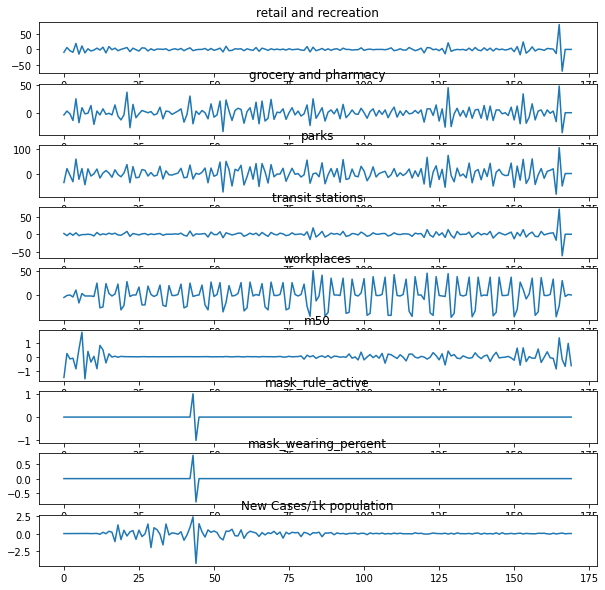

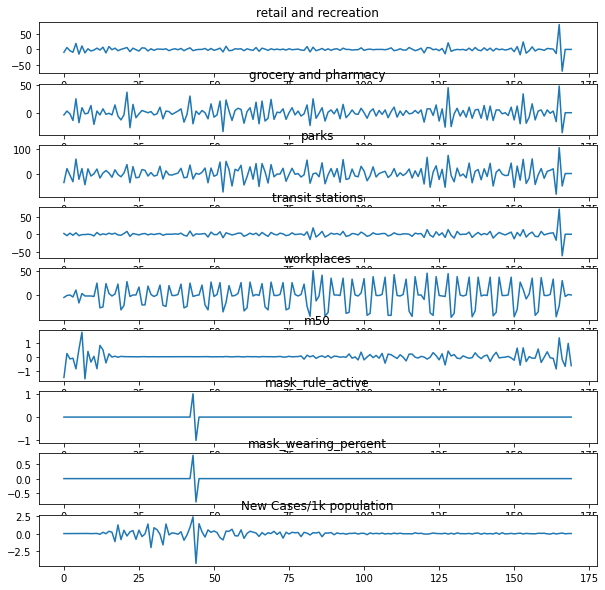

In [114]:
results.plot()

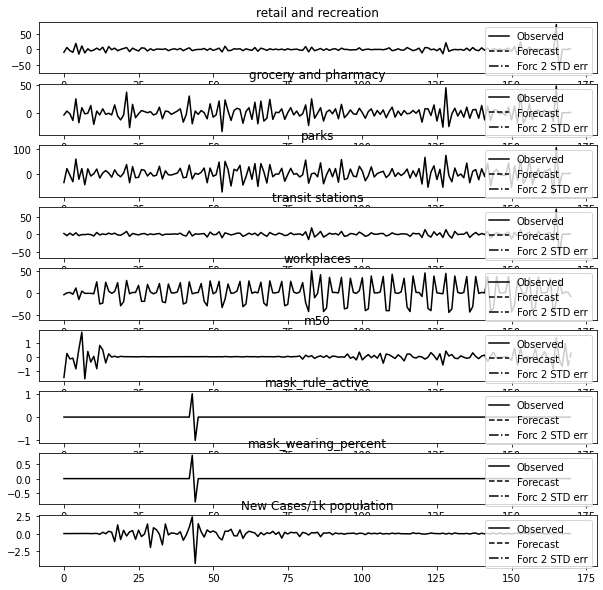

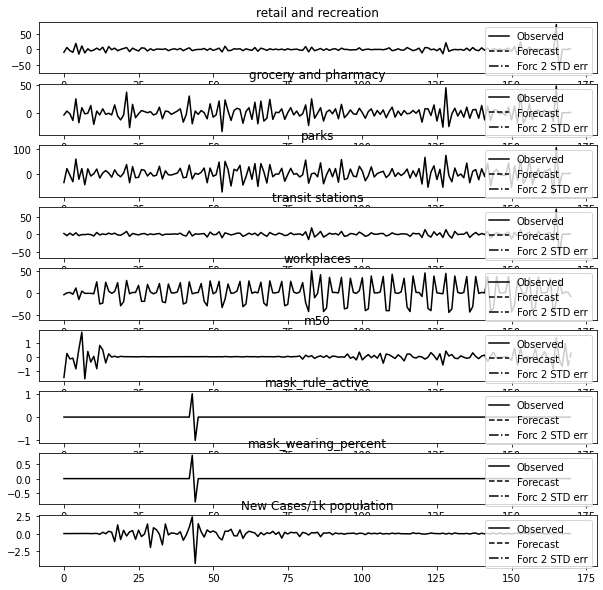

In [115]:
results.plot_forecast(1)

# VAR- Implementation- Unused

In [53]:
NY_labeled_data['County Name'].unique

<bound method Series.unique of 0          Albany County
1           Yates County
2        Columbia County
3       Schoharie County
4        Franklin County
              ...       
9799       Seneca County
9800     Cortland County
9801      Steuben County
9802      Suffolk County
9803        Yates County
Name: County Name, Length: 9804, dtype: object>

In [54]:
NY_labeled_data[NY_labeled_data['County Name']=='Albany County']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000,0,0.000000,305506.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
113,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000,0,0.000000,305506.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
157,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000,0,0.000000,305506.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
186,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000,0,0.000000,305506.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
275,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000,0,0.000000,305506.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532,2020-08-17,36001,Albany County,0.0,0.0,0.0,0.0,-45.0,12.0,37.64,2.712,56,584.364958,1,0.788,3,8.142857,305506.0,LessSpread,mild_decrement,0.009820,mild_growth,0.009820
9597,2020-08-18,36001,Albany County,0.0,0.0,0.0,0.0,-43.0,12.0,44.94,3.480,72,584.364958,1,0.788,4,6.714286,305506.0,LessSpread,mild_decrement,0.013093,mild_decrement,-0.015099
9666,2020-08-19,36001,Albany County,0.0,0.0,0.0,0.0,-44.0,12.0,53.30,3.112,65,584.364958,1,0.788,14,7.285714,305506.0,LessSpread,mild_decrement,0.045826,mild_decrement,-0.121792
9708,2020-08-20,36001,Albany County,0.0,0.0,0.0,0.0,-43.0,11.0,58.89,3.448,72,584.364958,1,0.788,9,6.857143,305506.0,LessSpread,mild_decrement,0.029459,mild_decrement,-0.016257


## Filter Data

In [211]:
columns = ['Date', 'fips_x','retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 
       'mask_rule_active', 'mask_wearing_percent','New Cases/1k population']

#NY_labeled_data_filter = NY_labeled_data.filter(columns, axis=1)
NY_labeled_data_filter = NY_labeled_data[NY_labeled_data['County Name']=='Albany County'].filter(columns, axis=1)

In [212]:
NY_labeled_data_filter.shape

(172, 14)

In [213]:
NY_labeled_data_filter.isnull().sum()

Date                       0
fips_x                     0
retail and recreation      0
grocery and pharmacy       0
parks                      0
transit stations           0
workplaces                 0
residential                0
driving                    0
m50                        0
m50_index                  0
mask_rule_active           0
mask_wearing_percent       0
New Cases/1k population    0
dtype: int64

In [214]:
NY_labeled_data_filter.index

Int64Index([   0,  113,  157,  186,  275,  341,  350,  426,  496,  530,
            ...
            9284, 9293, 9373, 9445, 9491, 9532, 9597, 9666, 9708, 9782],
           dtype='int64', length=172)

In [215]:
NY_labeled_data_filter.describe()

,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
count,172.0,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,36001.0,-37.906977,-4.918605,34.069767,-38.616279,-37.813953,13.087209,-1.298314,1.795488,37.087209,0.738372,0.581837,0.050736
std,0.0,19.685021,12.350832,53.874728,17.929471,18.562373,7.812006,33.492207,1.470396,30.739016,0.440804,0.347354,0.048890
min,36001.0,-80.000000,-53.000000,-55.000000,-66.000000,-77.000000,-1.000000,-64.270000,0.030000,0.000000,0.000000,0.000000,0.000000
25%,36001.0,-54.000000,-13.000000,0.000000,-53.000000,-52.000000,7.000000,-33.972500,0.251000,5.000000,0.000000,0.000000,0.019640
50%,36001.0,-38.000000,-6.000000,28.500000,-40.000000,-44.000000,13.000000,1.430000,1.859500,38.500000,1.000000,0.788000,0.039279
75%,36001.0,-28.000000,0.250000,66.250000,-31.000000,-26.500000,19.000000,27.640000,2.828750,59.000000,1.000000,0.788000,0.065465
max,36001.0,12.000000,37.000000,278.000000,11.000000,7.000000,27.000000,71.680000,5.428000,113.000000,1.000000,0.788000,0.320779


## Make Date Index

In [216]:
NY_labeled_data_filter.tail(2)

,Date,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
9708,2020-08-20,36001,0.0,0.0,0.0,0.0,-43.0,11.0,58.89,3.448,72,1,0.788,0.029459
9782,2020-08-21,36001,0.0,0.0,0.0,0.0,-44.0,12.0,71.68,4.230,88,1,0.788,0.022913


In [217]:
NY_labeled_data_filter['Date_Time'] = pd.to_datetime(NY_labeled_data_filter['Date'])

In [218]:
NY_labeled_data_filter = NY_labeled_data_filter.set_index('Date_Time')

In [219]:
NY_labeled_data_filter.head(2)

,Date,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,,,
2020-03-01,2020-03-01,36001,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,0,0.0,0.0
2020-03-02,2020-03-02,36001,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,0,0.0,0.0


In [220]:
NY_labeled_data_filter = NY_labeled_data_filter.drop(['Date','fips_x'], axis=1)
NY_labeled_data_filter.head(2)

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,
2020-03-01,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,0,0.0,0.0
2020-03-02,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,0,0.0,0.0


In [221]:
NY_labeled_data_filter

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,
2020-03-01,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,0,0.000,0.000000
2020-03-02,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,0,0.000,0.000000
2020-03-03,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,0,0.000,0.000000
2020-03-04,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,0,0.000,0.000000
2020-03-05,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,0,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,0.0,0.0,0.0,0.0,-45.0,12.0,37.64,2.712,56,1,0.788,0.009820
2020-08-18,0.0,0.0,0.0,0.0,-43.0,12.0,44.94,3.480,72,1,0.788,0.013093
2020-08-19,0.0,0.0,0.0,0.0,-44.0,12.0,53.30,3.112,65,1,0.788,0.045826


## Visualize

In [222]:
NY_labeled_data_filter.dtypes

retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
mask_rule_active             int64
mask_wearing_percent       float64
New Cases/1k population    float64
dtype: object

In [223]:
S1 = NY_labeled_data_filter['retail and recreation'].fillna(NY_labeled_data_filter['retail and recreation'].mean())
S2 = NY_labeled_data_filter['grocery and pharmacy'].mean()
S3 = NY_labeled_data_filter['parks'].fillna(NY_labeled_data_filter['parks'].mean())
S4 = NY_labeled_data_filter['transit stations'].fillna(NY_labeled_data_filter['transit stations'].mean())
S5 = NY_labeled_data_filter['workplaces'].fillna(NY_labeled_data_filter['workplaces'].mean())
S6 = NY_labeled_data_filter['residential'].fillna(NY_labeled_data_filter['residential'].mean())
S7 = NY_labeled_data_filter['driving'].fillna(NY_labeled_data_filter['driving'].mean())
S8 = NY_labeled_data_filter['m50'].fillna(NY_labeled_data_filter['m50'].mean())
S9 = NY_labeled_data_filter['m50_index'].fillna(NY_labeled_data_filter['m50_index'].mean())
S11 = NY_labeled_data_filter['mask_rule_active'].fillna(NY_labeled_data_filter['mask_rule_active'].mean())
S12 = NY_labeled_data_filter['mask_wearing_percent'].fillna(NY_labeled_data_filter['mask_wearing_percent'].mean())
S13 = NY_labeled_data_filter['New Cases/1k population'].fillna(NY_labeled_data_filter['New Cases/1k population'].mean())

Text(0.5, 1.0, 'driving')

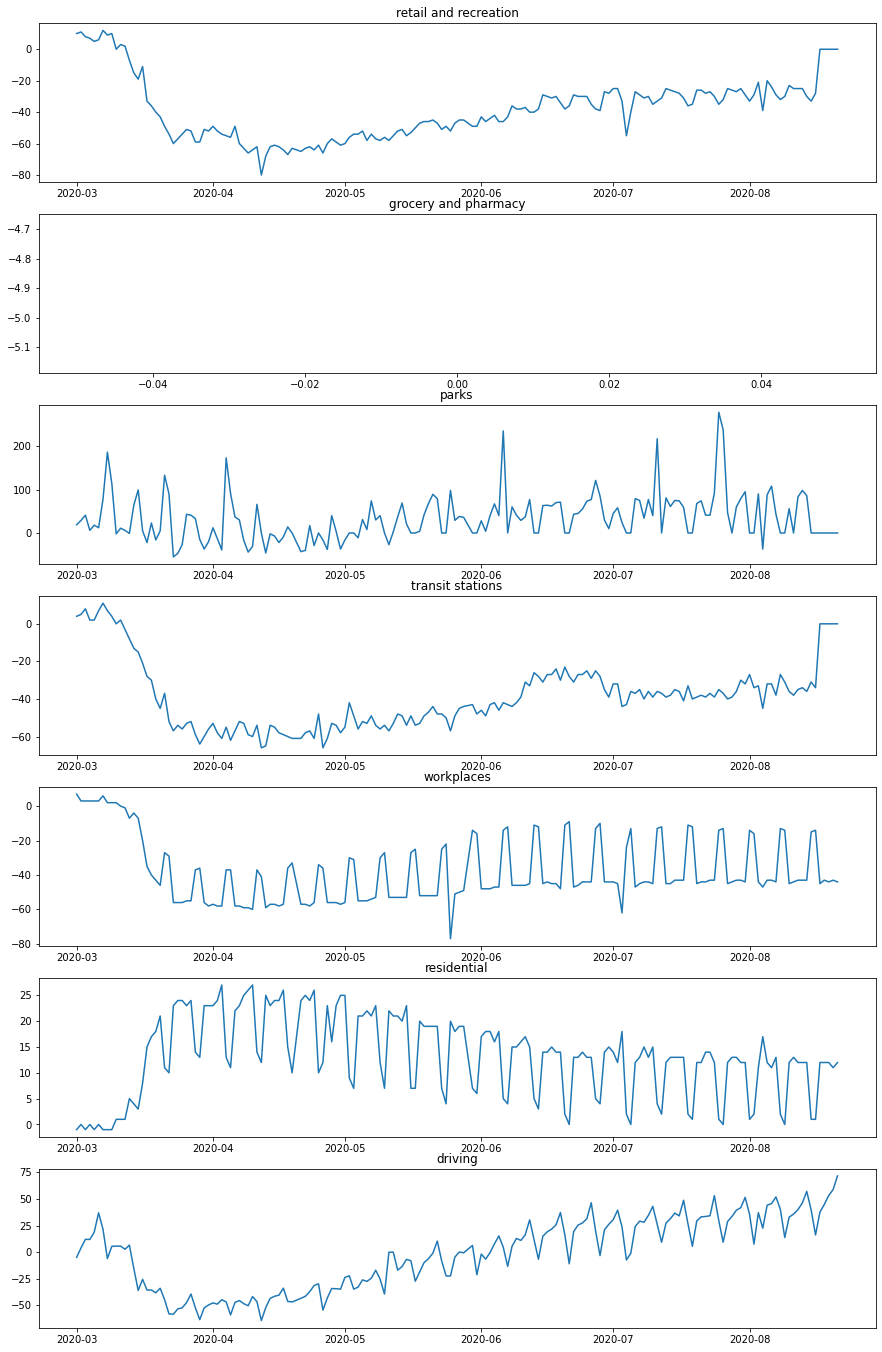

In [224]:
fig, axes = plt.subplots(7,1, figsize=(15,24))

axes[0].plot(S1)
axes[0].set_title ('retail and recreation')
axes[1].plot(S2)
axes[1].set_title ('grocery and pharmacy')
axes[2].plot(S3)
axes[2].set_title ('parks')
axes[3].plot(S4)
axes[3].set_title ('transit stations')
axes[4].plot(S5)
axes[4].set_title ('workplaces')
axes[5].plot(S6)
axes[5].set_title ('residential')
axes[6].plot(S7)
axes[6].set_title ('driving')


Text(0.5, 1.0, 'New Cases/1k population')

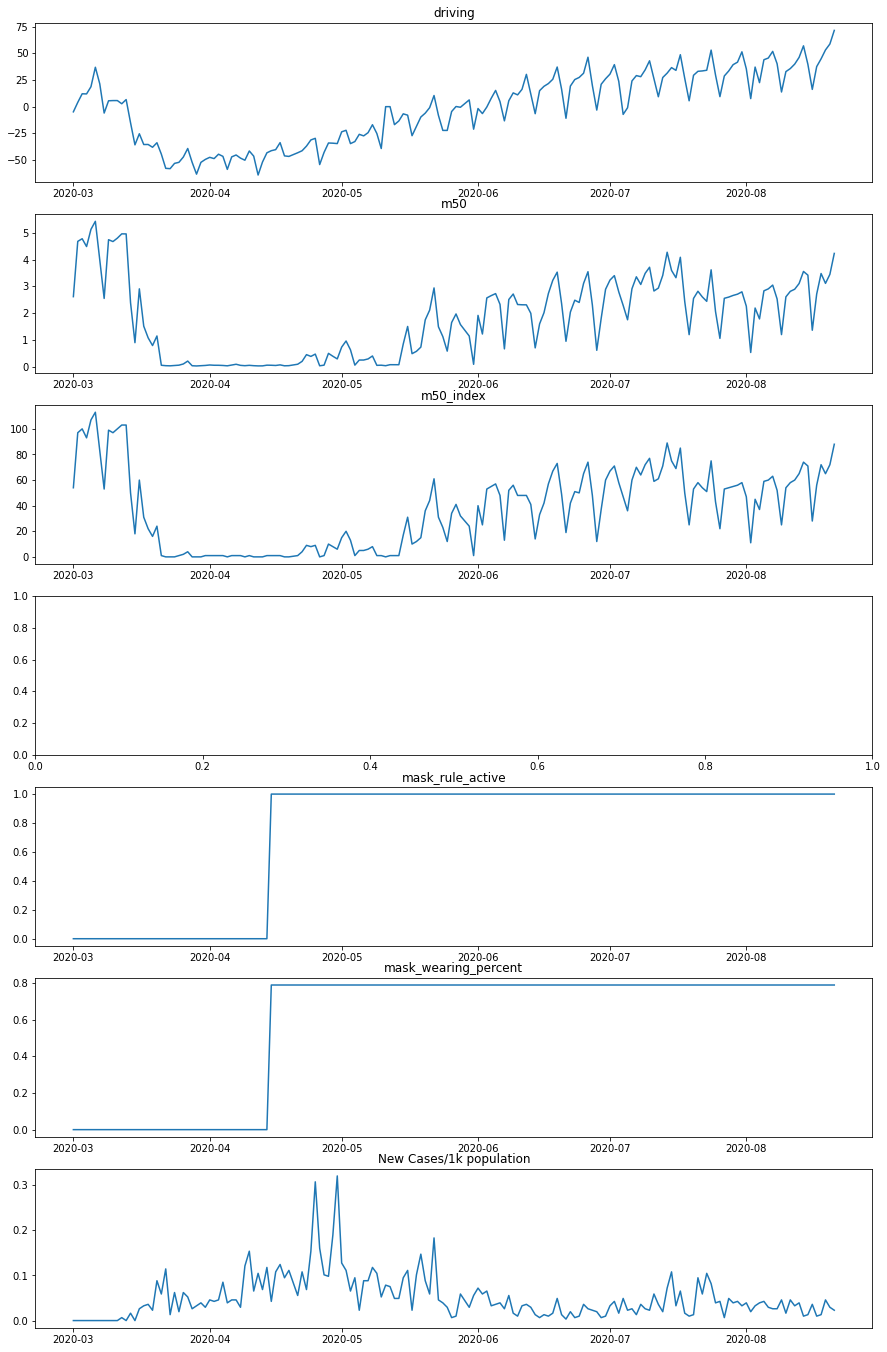

In [225]:
fig, axes = plt.subplots(7,1, figsize=(15,24))

axes[0].plot(S7)
axes[0].set_title ('driving')
axes[1].plot(S8)
axes[1].set_title ('m50')
axes[2].plot(S9)
axes[2].set_title ('m50_index')
#axes[3].plot(S10)
#axes[3].set_title ('population_density')
axes[4].plot(S11)
axes[4].set_title ('mask_rule_active')
axes[5].plot(S12)
axes[5].set_title ('mask_wearing_percent')
axes[6].plot(S13)
axes[6].set_title ('New Cases/1k population')

## Checking Stationarity- Eigen Value

In [226]:
NY_labeled_data_filter.columns

Index(['retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'residential', 'driving', 'm50',
       'm50_index', 'mask_rule_active', 'mask_wearing_percent',
       'New Cases/1k population'],
      dtype='object')

In [228]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = NY_labeled_data_filter.drop(['grocery and pharmacy'], axis=1) ## this column is giving neg value for eigen
coint_johansen(johan_test_temp,-1,1).eig

array([ 0.45773428,  0.43190023,  0.32710248,  0.30736524,  0.23090548,
        0.20054022,  0.1394041 ,  0.07961484,  0.06557554,  0.03118339,
       -0.09315501])

##Train-Validation Split

In [229]:
train = johan_test_temp[:int(0.8*(len(data)))]
print(train.shape)
valid = johan_test_temp[int(0.8*(len(data))):]
print(valid.shape)

(162, 11)
(10, 11)


In [71]:
nobs = 10
train = johan_test_temp[0:-nobs]
print(train.shape)
valid = johan_test_temp[-nobs:]
print(valid.shape)

(162, 12)
(10, 12)


##Stationarity

A stationary time series will more often than not give us a better set of predictions. Similar to the Augmented Dickey-Fuller test for univariate series, we have Johansen’s test for checking the stationarity of any multivariate time series data. Since the test works for only 12 variables, I have randomly dropped in the next iteration, I would drop another and check the eigenvalues.

coint_johansen()
statsmodels.tsa.vector_ar.vecm.coint_johansen(endog, det_order, k_ar_diff) - perform the Johansen cointegration test for determining the cointegration rank of a VECM.

endog - the data with presample.
det_order: int -
-1 - no deterministic terms.
0 - constant term.
1 - linear trend.
k_ar_diff: int, nonnegative - number of lagged differences in the model.

In [230]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test-not using this
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
  dftest = adfuller(ts, autolag='AIC')
  adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
  for key,value in dftest[4].items():
    adf['Critical Value (%s)'%key] = value
  print (adf)
  p = adf['p-value']
  if p <= signif:
    print(f" Series is Stationary")
  else:
    print(f" Series is Non-Stationary")

In [231]:
#apply adf test on the series-not using this


for i in train.columns:
  print(i)
  #adf_test(train[[i]])
adf_test(train["retail and recreation"])

retail and recreation
parks
transit stations
workplaces
residential
driving
m50
m50_index
mask_rule_active
mask_wearing_percent
New Cases/1k population
Test Statistic           -2.011313
p-value                   0.281635
# Lags                   13.000000
# Observations          148.000000
Critical Value (1%)      -3.475325
Critical Value (5%)      -2.881275
Critical Value (10%)     -2.577293
dtype: float64
 Series is Non-Stationary


In [232]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [233]:
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0113
 No. Lags Chosen       = 13
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.2816. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7384
 No. Lags Chosen       = 0
 Critical value 1%     = -3.472
 Critical value 5%     = -2.88
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "transit stations" 
    -----------------------------------------------
 Null Hypothesis: Data has un

## Make data stationery

### 1st Differencing

In [234]:
# 1st difference
df_differenced = train.diff().dropna()

In [235]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8318
 No. Lags Chosen       = 12
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0026. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.094
 No. Lags Chosen       = 12
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "transit stations" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

### 2nd Differencing

In [236]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [237]:

# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0527
 No. Lags Chosen       = 13
 Critical value 1%     = -3.476
 Critical value 5%     = -2.882
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.641
 No. Lags Chosen       = 14
 Critical value 1%     = -3.476
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "transit stations" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.

## Vector Autoregression (VAR) Model

In [238]:
#removing constant columns
train = train.loc[:, (train != train.iloc[0]).any()]


valid = valid.loc[:, (valid != valid.iloc[0]).any()]

In [239]:
df_differenced.columns

Index(['retail and recreation', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'mask_rule_active',
       'mask_wearing_percent', 'New Cases/1k population'],
      dtype='object')

In [241]:
print(df_differenced.shape)

df_differenced_unique = df_differenced.drop_duplicates()
print(df_differenced_unique.shape)

(160, 11)
(160, 11)


In [242]:
df_differenced_unique = df_differenced_unique.loc[:, (df_differenced_unique != df_differenced_unique.iloc[0]).any()]
print(df_differenced_unique.shape)

(160, 11)


In [244]:
df_differenced_unique.columns

Index(['retail and recreation', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'mask_rule_active',
       'mask_wearing_percent', 'New Cases/1k population'],
      dtype='object')

In [243]:
model = VAR(df_differenced_unique)
for i in [4,5,6,7,8,9]:
    result = model.fit(i)
    print(result)
    print('Lag Order =', i)
    print('AIC : ', result.aic) ## take lag value where aic is low
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 4


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: ignored

In [98]:
# Fit the model

model = VAR(endog=df_differenced_nonzero)
model_fit = model.fit()


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [99]:
## need to check why summary is giving error

model_fit.summary()

LinAlgError: ignored

## Forecasting

In [83]:
# Make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))


/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


## Accuracy

In [84]:
NY_labeled_data_filter.dtypes

retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
mask_rule_active             int64
mask_wearing_percent       float64
New Cases/1k population    float64
dtype: object

In [85]:
train.dtypes

retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
mask_rule_active             int64
mask_wearing_percent       float64
New Cases/1k population    float64
dtype: object

In [86]:
# Convert array to DataFrame
cols = valid.columns #NY_labeled_data_filter.columns
pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])

for j in range(0, len(cols)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]
print(cols)

Index(['retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'residential', 'driving', 'm50',
       'm50_index', 'New Cases/1k population'],
      dtype='object')


### RMSE

In [87]:
# RMSE
import math
for i in cols:
    print(i)
    print('RMSE value for', i, 'is:', math.sqrt(mean_squared_error(pred[[i]], valid[[i]])))

retail and recreation
RMSE value for retail and recreation is: 20.821811628373105
grocery and pharmacy
RMSE value for grocery and pharmacy is: 5.402576273516499
parks
RMSE value for parks is: 49.56905508658742
transit stations
RMSE value for transit stations is: 23.76425704368648
workplaces
RMSE value for workplaces is: 38.983582949331996
residential
RMSE value for residential is: 10.648739608713774
driving
RMSE value for driving is: 48.97777723825501
m50
RMSE value for m50 is: 3.2206976826373723
m50_index
RMSE value for m50_index is: 66.97796235330786
New Cases/1k population
RMSE value for New Cases/1k population is: 0.02950470097790948


## Final Prediction

In [88]:
# Make final predictions
model = VAR(endog=NY_labeled_data_filter)
model_fit = model.fit()



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [92]:
#model_fit.summary()

LinAlgError: ignored

In [90]:
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[ 2.46652198e-01  4.14998645e+00  4.58777048e+01  1.74421267e+00
  -2.82437209e+01  6.62940612e+00  7.20563802e+01  4.28478023e+00
   8.92442242e+01  1.02614161e+00  8.08599589e-01  8.05367664e-03]]


/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


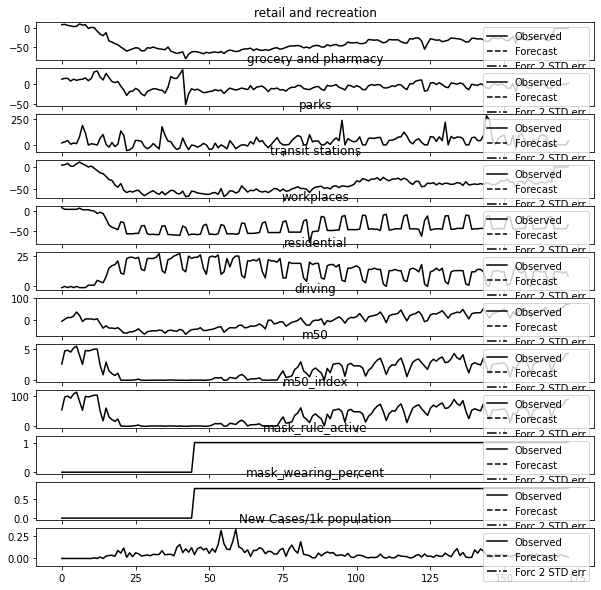

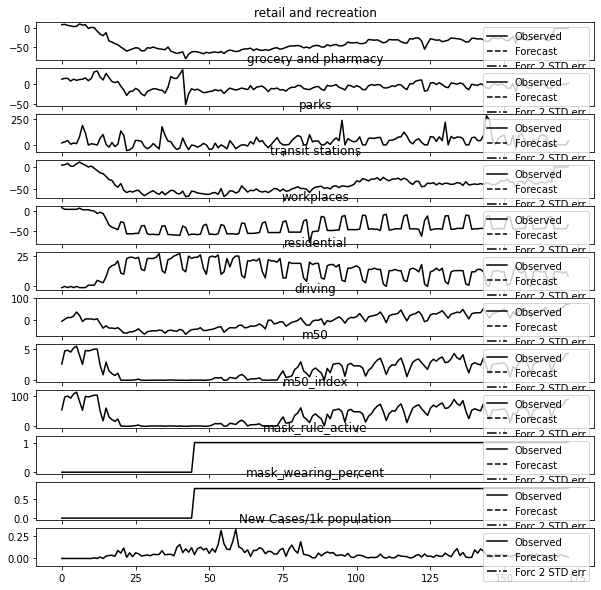

In [91]:
model_fit.plot_forecast(1)